# Team Compositions in Professional League of Legends
***

The data being used was obtained from [Oracle's Elixer] (using upload from September 18th, 2017). A [codebook] for the variables is also included.

[Oracle's Elixer]: http://oracleselixir.com/match-data/
[codebook]: http://oracleselixir.com/match-data/match-data-dictionary/

## Prepare Workspace and Get Data

To gather the data, I downloaded a series of .xlsx files from links, read them into a pandas dataframe and concatenated them together. I also saved this initial dataset for reproducibility (and for consistency in the event the original .xlsx files are updated as I build out my analysis).

**Update**: Because the files and format at the host site have changed since I started this project, the initial script will no longer work, and data is being read in from a saved csv of the initial raw data. Original code is commented out for referrence. Also the host changed scraping permissions, so the code would have to be changed to include `import requests` and `requests.get(url).content` as object being passed to `pd.read_excel()`.

In [1]:
%%capture
# To keep these documents from getting untidy
# support_functions.py in this repo containts
# all necessary package imports and custom functions
from support_functions import *
%matplotlib inline

In [2]:
%%capture
# to supress dtype warnings

# # List of excel file url's to read and join together
# root_url = "http://oracleselixir.com/gamedata/"
# urls = ["2016-spring/", "2017-spring/", "2017-summer/"]
# urls = [root_url + url for url in urls]

# partial_dfs = [pd.read_excel(url, 'Sheet1') for url in urls]
# df = pd.concat(partial_dfs, ignore_index = True)

# # Save df as a csv for future work.
# df.to_csv(r'data\Raw-LoL-Data.csv')

# Read df from csv if the files have been updated.
df = pd.read_csv('data/Raw-LoL-Data.csv', encoding = "ISO-8859-1", index_col = 0)

**Examine the data**

In [20]:
print(df.sample())
print(df.info())

           gameid                                                url league  \
19588  1001770120  http://matchhistory.na.leagueoflegends.com/en/...  NALCS   

        split          date week game  patchno  playerid  side   ...     \
19588  2016-2  42561.618484  6.3    2     6.13         5  Blue   ...      

           cspm goldat10 oppgoldat10 gdat10 goldat15 oppgoldat15 gdat15  \
19588  0.552389   2006.0      1825.0  181.0   3649.0      3269.0  380.0   

       xpat10 oppxpat10  xpdat10  
19588  2616.0    3093.0   -477.0  

[1 rows x 92 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 64692 entries, 0 to 64691
Data columns (total 92 columns):
gameid                     64692 non-null object
url                        54108 non-null object
league                     64692 non-null object
split                      64692 non-null object
date                       57937 non-null float64
week                       64692 non-null object
game                       64692 non-null 

There's a wall of text there. But it's clear that quite a few variables have some dtype issues. There are 33 object type columns that correspond to either numeric or categorical variables, they need to be recast for analysis. There are also two numeric types (patchno and playerid) that need to be coerced to categorical variables.

In [21]:
df.select_dtypes(include = ['object']).columns

Index(['gameid', 'url', 'league', 'split', 'week', 'game', 'side', 'position',
       'player', 'team', 'champion', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5',
       'doubles', 'triples', 'quadras', 'pentas', 'fb', 'fbvictim', 'fbtime',
       'kpm', 'okpm', 'ckpm', 'fd', 'dmgshare', 'earnedgoldshare',
       'visionwards', 'visiblewardclearrate', 'invisiblewardclearrate',
       'monsterkillsenemyjungle'],
      dtype='object')

In [3]:
#Filter object type columns that will be converted to numeric.
objCols = df.select_dtypes(include = ['object']).columns\
    .drop(['gameid', 'url', 'league', 'split', 'week', 'game',
           'side', 'position', 'player', 'team', 'champion',
           'ban1', 'ban2', 'ban3', 'ban4', 'ban5'])

for col in objCols:
    try:
        df[col] = pd.to_numeric(df[col], errors = 'coerce')
    except:
        print('Column {} cannot be converted to numeric.'.format(col))

In [4]:
objCols = ['league', 'split', 'week', 'game', 'side', 'position',
           'player', 'team', 'champion', 'ban1', 'ban2', 'ban3',
           'ban4', 'ban5', 'playerid', 'patchno']
df[objCols] = df[objCols].apply(pd.Categorical)

**NOTE** --- 'date' column conversion error:

The 'date column was originally being read as a float. My guess was that this meant pandas was taking a date like 2017/04/23 and interpretting it as: $\frac{2017}{\frac{4}{23}} $

I attempted to read in the 'date' column as a string to see how it was formatted so that I would know the correct parsing syntax to read it as a datetime. However, the problem with the date showing up as a float still remained. I tried looking at the column in one of the smaller .xlsx files directly and the problem was present even there, leading my to suspect the entire column was miscast when the dataset was created.

In [15]:
# file host changed format, you'll have to use requests package
# to get this working now.
# import requests, give requests.get(url).content to ExcelFile()
dateTest = pd.ExcelFile("http://oracleselixir.com/gamedata/2016-spring/")
dateTestDF = pd.read_excel(dateTest, 'Sheet1', nrows = 10,
                           usecols = ['date'], dtype = {'date': str})

print(dateTestDF)
print(dateTestDF.info())
print(type(dateTestDF.iloc[0,0]))

                date
0  42578.11311342593
1  42578.11311342593
2  42578.11311342593
3  42578.11311342593
4  42578.11311342593
5  42578.11311342593
6  42578.11311342593
7  42578.11311342593
8  42578.11311342593
9  42578.11311342593
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 1 columns):
date    10 non-null object
dtypes: object(1)
memory usage: 160.0+ bytes
None
<class 'str'>


Excel has its own way of handling dates which is notoriously uncooperative with other formats. Luckily, there are other features that can be used to order observations if needed (`split`, `week`, etc).

**Make `gameid` unique**:

Noticed this problem very late in the analysis originally. `gameid` which should be a unique identifier for each game is repeated a few times. There should be 12 observations per `gameid` (10 players, 2 teams), however...

In [5]:
print('There are {} unique games, and observations/12 is {}.'\
      .format(df['gameid'].nunique(), df.shape[0]/12))

There are 5329 unique games, and observations/12 is 5391.0.


In [6]:
# corrects the error by giving duplicate gameid's a 'b' at the end
dbl_idx = df.groupby('gameid').gameid.count()
dbl_idx = dbl_idx[dbl_idx >12]
dbl_idx = dbl_idx.index.to_series()

print("Unique gameid's before:",df.gameid.nunique())
for i in dbl_idx:
    first_week = df[df.gameid == i].week.values[0]
    df.loc[(df.gameid == i) & \
                 (df.week != first_week), 'gameid'] = i + 'b'
print("Unique gameid's after:",df.gameid.nunique())

Unique gameid's before: 5329
Unique gameid's after: 5391


***
### Segmenting the data:

Now that the column data types have been properly coerced, and gameid corrected, the data should be split into two separate data frames - one for team level data and the other for individual player data. This way all observations will refer to the same type of data.

In [7]:
teamDF = df.loc[df['player'] == 'Team', :]
playerDF = df.loc[df['player'] != 'Team', :]
teamDF.is_copy = False
playerDF.is_copy = False
# save these for easy access
enpickle(teamDF, 'data/teamDF.pickle')
enpickle(playerDF, 'data/playerDF.pickle')

Before getting into EDA, there's an elephant in the room and it's a big one...

## Missing Values

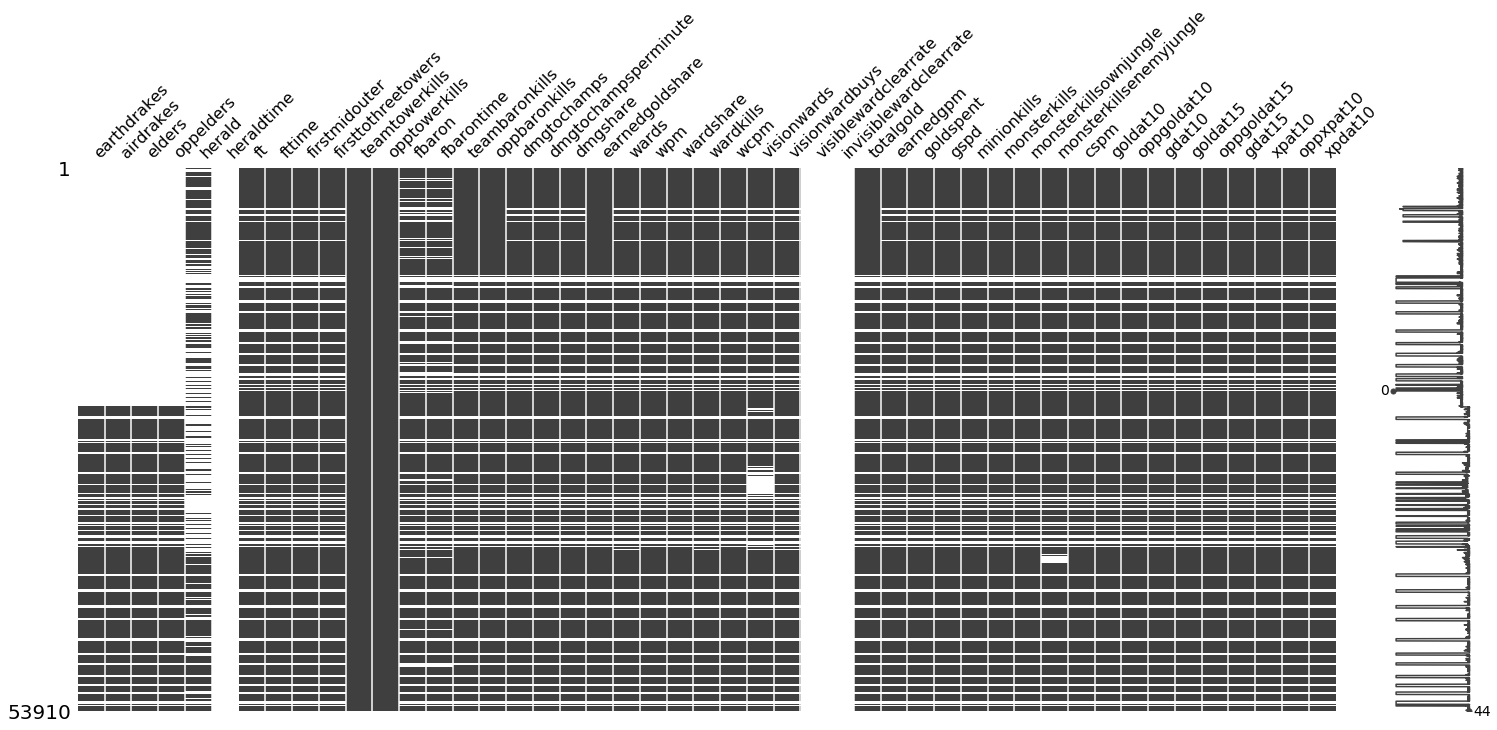

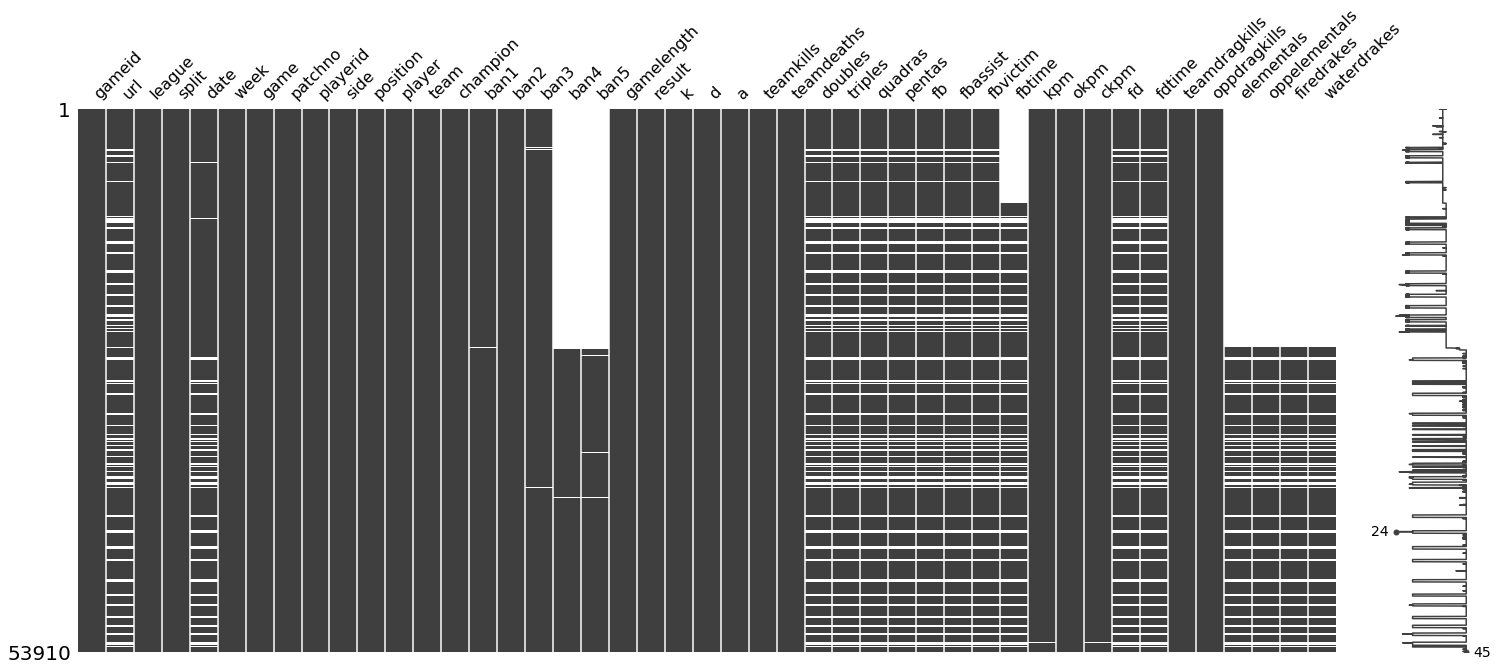

In [8]:
ax = missingno.matrix(playerDF.iloc[:,45:])
ax = missingno.matrix(playerDF.iloc[:,:45])

There are **huge** patches of observations with most of their values missing. That's a problem. A little digging around shows the culprit is the LPL league.

In [9]:
playerDF[playerDF.isnull().sum(axis=1) > 15].league.value_counts()[:5]

LPL      8810
LCK       290
LMS       245
CBLoL     170
NALCS     140
Name: league, dtype: int64

Removing the LPL produces much cleaner data.

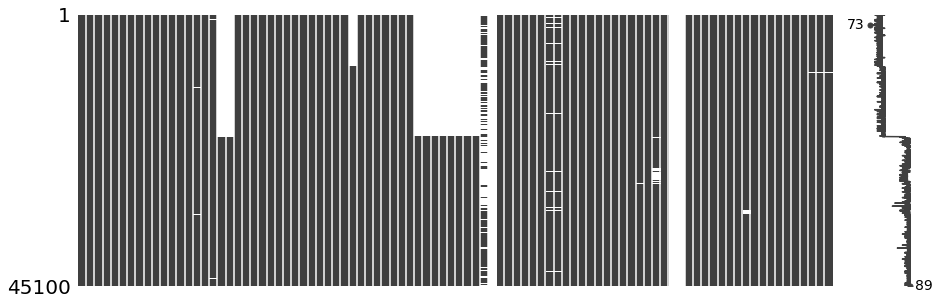

In [10]:
ax = missingno.matrix(playerDF[playerDF.league != 'LPL'],
                 fontsize=10,figsize=(15,5),labels = False)

In [11]:
missing_values_table(playerDF[playerDF.league == 'LPL'], 'both')\
    .sort_values(by = 'missing', ascending = False)

56 Columns with no values:  ['url', 'doubles', 'triples', 'quadras', 'pentas', 'fb', 'fbassist', 'fbvictim', 'fbtime', 'fd', 'fdtime', 'elementals', 'oppelementals', 'firedrakes', 'waterdrakes', 'earthdrakes', 'airdrakes', 'elders', 'oppelders', 'herald', 'heraldtime', 'ft', 'fttime', 'firstmidouter', 'firsttothreetowers', 'fbaron', 'fbarontime', 'dmgtochamps', 'dmgtochampsperminute', 'dmgshare', 'wards', 'wpm', 'wardshare', 'wardkills', 'wcpm', 'visionwards', 'visionwardbuys', 'visiblewardclearrate', 'invisiblewardclearrate', 'earnedgpm', 'goldspent', 'gspd', 'minionkills', 'monsterkills', 'monsterkillsownjungle', 'monsterkillsenemyjungle', 'cspm', 'goldat10', 'oppgoldat10', 'gdat10', 'goldat15', 'oppgoldat15', 'gdat15', 'xpat10', 'oppxpat10', 'xpdat10']

 19 columns with all values present:  ['gameid', 'league', 'split', 'week', 'game', 'patchno', 'playerid', 'side', 'position', 'player', 'team', 'champion', 'gamelength', 'result', 'k', 'd', 'a', 'teamkills', 'teamdeaths']


,missing,missing_percent,vals,value_percent
totalgold,8140,92.395006,670,7.604994
earnedgoldshare,8140,92.395006,670,7.604994
teambaronkills,8130,92.281498,680,7.718502
oppbaronkills,8130,92.281498,680,7.718502
date,5687,64.551646,3123,35.448354
ban5,3520,39.954597,5290,60.045403
ban4,3475,39.443814,5335,60.556186
ban3,40,0.454030,8770,99.545970
ckpm,40,0.454030,8770,99.545970
kpm,30,0.340522,8780,99.659478


It appears that the LPL has complete information on nearly all the pre-game data (team, patch, player, position, side, picks and bans), and some of the in-game data (kills/deaths/assists and their derivations, result, tower and dragon kills). Everything else is missing.

This makes the data mostly unusable. No form of imputation will really be viable with observations containing so many missing values. The end goal of this analysis will be to build a predictor using exclusively pregame information. The intact pregame information means it's possible to use this LPL data as an extra validation set.

However, it should be noted that China (the LPL) has historically played its own unique style (often called the 'bloodbath meta' as it favors engage or pick heavy compositions with tons of skirmishes and teamfights) - so testing a model against data completely different from what it was built on may not work out too well.

In addition to the problematic LPL data, it's also clear from the first missing values plot that nearly half of all entries are missing data for elemental drakes, which makes sense as this is a game mechanic that was changed in the middle of the period the observations come from. These features represent an important part of the game, but there's no way fairly compare them across the observations. Perhaps when more data is available, this analysis can be redone with only games having the newer elemental drake mechanic. For now however, these features will be dropped (same story for the rift herald).

While this is taken care of, the player data will also be split into separate dataframes for each position.

In [59]:
# create a dict of DFs - one for each position
playerDF.patchno = playerDF.patchno.astype(str)
raw_players = {key:playerDF.loc[playerDF.position == key].copy()\
               for key in playerDF.position.unique()}

# specify drop columns
drops = [c for c in playerDF.columns if \
         any(sub in c for sub in ['drag', 'drake', 'elem', 'eld'])] + \
        ['url', 'split', 'date', 'week', 'game',
         'playerid', 'herald','heraldtime']
    
# drop LPL games, drop columns, and empty columns
for k, df in raw_players.items():
    df.drop(drops, axis = 1, inplace=True)
    df.dropna(axis = 1, how='all', inplace = True)
    df.drop(df[df.league == 'LPL'].index, inplace=True)
    
# repeat for teamraw_teams
raw_teams = teamDF.copy()
raw_teams.dropna(axis = 1, how='all', inplace = True)
raw_teams.drop(raw_teams[raw_teams.league == 'LPL'].index, inplace=True)
raw_teams.drop(drops, axis = 1, inplace=True)

As for actually imputing the missing values, it would be imprudent to simply mean/median fill. The shape of the missing values suggests that they were Missing at Random (MAR) rather than completely at random (MCAR) - meaning there is a pattern to why and where they are missing. There are a lot of advanced imputation options for MAR data such as MICE, knn, and SoftImpute to name a few.

In search of a the best imputation technique, I've built a function to test the quality of an imputation method. The function takes a scaled dataframe and method as a required argument, samples the rows without missing values and spikes in missing values proportionate to their missing percentage in the full dataframe. This dummy data is then imputed with the provided method and its result is compared against the true data by root mean-squared error (RMSE). This process is performed across a given number of iterations (default 20) and the final return of the function is a list of RMSE values for each iteration.

Since that function requires scaled data (as some of the imputers infer relationships by feature distance), the raw_players data will be standard scaled (keeping track of $\mu$ and $\sigma$ to reverse transform later), with one slight difference - the observations will be grouped by patch number and scaled accordingly (ie by $\mu_{patch}$ and $\sigma_{patch}$). This way large variations in playstyle across different iterations of the game don't over/under influence the imputation.

**Note:** This patch-wise scaling technique will be performed throughout the analysis for the exact same reason.

In [49]:
scale_players = {}
scale_ref = {}
b_cols = {}
for k,df in raw_players.items():
    b_cols[k] = get_bin_cols(df).tolist() + ['triples','quadras','pentas']
    b_cols[k] = list(set(b_cols[k]))
    scale_ref[k] = get_feature_scale_dict(df,'patchno', b_cols[k])
    scale_players[k] = patch_scale(df, scale_ref[k],verbose = True)

WARNING - Unable to transform: [('5.24', 'fbtime'), ('6.01', 'fbtime'), ('6.02', 'fbtime'), ('6.03', 'fbtime'), ('6.04', 'fbtime'), ('6.05', 'fbtime'), ('6.06', 'fbtime'), ('6.07', 'fbtime'), ('7.04', 'visionwards')]
WARNING - Unable to transform: [('5.24', 'fbtime'), ('6.01', 'fbtime'), ('6.02', 'fbtime'), ('6.03', 'fbtime'), ('6.04', 'fbtime'), ('6.05', 'fbtime'), ('6.06', 'fbtime'), ('6.07', 'fbtime'), ('7.04', 'visionwards')]
WARNING - Unable to transform: [('5.24', 'fbtime'), ('6.01', 'fbtime'), ('6.02', 'fbtime'), ('6.03', 'fbtime'), ('6.04', 'fbtime'), ('6.05', 'fbtime'), ('6.06', 'fbtime'), ('6.07', 'fbtime'), ('7.04', 'visionwards')]
WARNING - Unable to transform: [('5.24', 'fbtime'), ('6.01', 'fbtime'), ('6.02', 'fbtime'), ('6.03', 'fbtime'), ('6.04', 'fbtime'), ('6.05', 'fbtime'), ('6.06', 'fbtime'), ('6.07', 'fbtime'), ('7.04', 'visionwards')]
WARNING - Unable to transform: [('5.24', 'doubles'), ('7.17', 'doubles'), ('5.24', 'fbtime'), ('6.01', 'fbtime'), ('6.02', 'fbtime')

In [62]:
raw_teams.patchno = raw_teams.patchno.astype(str)
team_b_cols = get_bin_cols(raw_teams).tolist() + ['triples','quadras','pentas']
team_b_cols = list(set(team_b_cols))
team_ref = get_feature_scale_dict(raw_teams,'patchno', team_b_cols)
scale_team = patch_scale(raw_teams, team_ref,verbose = True)

WARNING - Unable to transform: [('7.04', 'visionwards'), ('5.24', 'visiblewardclearrate'), ('7.04', 'visiblewardclearrate'), ('7.04', 'invisiblewardclearrate')]


Some features were unable to be scaled (due to all 0's or all missing for feature in patch). `fbtime` clearly wasn't tracked until after patch 6.07, and `visionwards` appear to have not been tracked in 7.04, which is probably an error with how the data was collected. None of these will be too big a problem for the imputer though.

---

### Imputation Testing

Testing will be done as previously described, considering the following techniques:
- KNN
- MICE
- SoftImpute
- Iterative-SVD
- Mean Impute
- Median Impute

Each tecnique will be tested across a range of hyperparameters (if applicable) as well with different feature behaviors when calculating RMSE.

Different behaviors are:
- Include binary features in calculation
- Exclude binary features
- Include binary features but round up/down before calculation

** WARNING - Long Runtime Ahead **

The following tests will take about 30 minutes depending on the computer. A json of the test outputs has been included in the repository with this notebook as a shortcut around running all the tests. Just uncomment and run the code below to save time. Randomization seed was controlled for in the test functions, so results will be the same for the deterministic imputing algorithms (not the stochastic, tried to control for that as well but ran into issues with nested \*\*kwargs). Then skip ahead to [here](#Imputation-Test-Results).

In [40]:
# uncomment this if you want the precomputed imputation results
# with open('data/rmse_dict.json', 'r') as f:
#      rmse_dict = json.load(f)

In [ ]:
rmse_dict = {k:{'knn':{},'mice':{}} for k in ['with_bin','no_bin','round_bin']}

### K Nearest Neighbors (KNN)
---
#### -- Include Binary Feature Estimates

In [ ]:
base_proc = 'fancyimpute.KNN({}, verbose=False).complete'
rmse_dict['with_bin']['knn']['1'] = show_test(scale_players, base_proc.format(1), **{'round_bin':False})

In [ ]:
for n in [3,5,7,9]:
    proc = base_proc.format(n)
    rmse_dict['with_bin']['knn'][str(n)] = show_test(scale_players, proc, verbose=False,**{'round_bin':False})

---
#### -- Round Binary Feature Estimates

In [ ]:
for n in [1,3,5,7,9]:
    proc = base_proc.format(n)
    rmse_dict['round_bin']['knn'][str(n)] = show_test(scale_players, proc, verbose=False,**{'round_bin':True})

---
#### -- Ignore Binary Features

In [ ]:
for n in [1,3,5,7,9]:
    proc = base_proc.format(n)
    rmse_dict['no_bin']['knn'][str(n)] = show_test(scale_players, proc, verbose=False,**{'ignore_bin':True})

### Multiple Imputation by Chained Equations (MICE) - using Bayesian Ridge Regression
---
#### -- Include Binary Feature Estimates

In [ ]:
base_proc = 'fancyimpute.MICE(verbose=False,model=fancyimpute.BayesianRidgeRegression(lambda_reg={},\
    add_ones=True)).complete'

for l in [.25, 0.1, 0.01, 0.001, 0.0001]:
    proc = base_proc.format(l)
    rmse_dict['round_bin']['mice'][str(l)] = show_test(scale_players, proc, verbose=False, **{'round_bin':False})

---
#### -- Round Binary Feature Estimates

In [ ]:
for l in [.25, 0.1, 0.01, 0.001, 0.0001]:
    proc = base_proc.format(l)
    rmse_dict['round_bin']['mice'][str(l)] = show_test(scale_players, proc, verbose=False, **{'round_bin':True})

---
#### -- Ignore Binary Features

In [ ]:
for l in [.25, 0.1, 0.01, 0.001, 0.0001]:
    proc = base_proc.format(l)
    rmse_dict['no_bin']['mice'][str(l)] = show_test(scale_players, proc, verbose=False, **{'ignore_bin':True})

### Mean
---
#### -- Include Binary Feature Estimates

In [ ]:
proc = 'Imputer().fit_transform'
rmse_dict['with_bin']['mean'] = show_test(scale_players, proc, **{'round_bin':False})

---
#### -- Round Binary Feature Estimates

In [ ]:
rmse_dict['round_bin']['mean'] = show_test(scale_players, proc, verbose = False, **{'round_bin':True})

---
#### -- Ignore Binary Features

In [ ]:
rmse_dict['no_bin']['mean'] = show_test(scale_players, proc, verbose = False, **{'ignore_bin':True})

### Median
---
#### -- Include Binary Feature Estimates

In [ ]:
proc = 'Imputer(strategy="median").fit_transform'
rmse_dict['with_bin']['median'] = show_test(scale_players, proc, **{'round_bin':False})

---
#### -- Round Binary Feature Estimates

In [ ]:
rmse_dict['round_bin']['median'] = show_test(scale_players, proc,verbose=False, **{'round_bin':True})

---
#### -- Ignore Binary Features

In [ ]:
rmse_dict['no_bin']['median'] = show_test(scale_players, proc,verbose=False, **{'ignore_bin':True})

### Soft Impute
---
#### -- Include Binary Feature Estimates

In [ ]:
proc = 'fancyimpute.SoftImpute(verbose=False).complete'
rmse_dict['with_bin']['soft'] = show_test(scale_players, proc, **{'round_bin':False})

---
#### -- Round Binary Feature Estimates

In [ ]:
rmse_dict['round_bin']['soft'] = show_test(scale_players, proc,verbose=False, **{'round_bin':True})

---
#### -- Ignore Binary Features

In [ ]:
rmse_dict['no_bin']['soft'] = show_test(scale_players, proc,verbose=False, **{'ignore_bin':True})

### Iterative-SVD
---
#### -- Include Binary Feature Estimates

In [ ]:
proc = 'fancyimpute.IterativeSVD(verbose=False).complete'
rmse_dict['with_bin']['svd'] = show_test(scale_players, proc, **{'round_bin':False})

---
#### -- Round Binary Feature Estimates

In [ ]:
rmse_dict['round_bin']['svd'] = show_test(scale_players, proc,verbose=False, **{'round_bin':True})

---
#### -- Ignore Binary Features

In [ ]:
rmse_dict['no_bin']['svd'] = show_test(scale_players, proc,verbose=False, **{'ignore_bin':True})

### Additional Tests

Judging effectiveness of an imputation method on a sample size a tenth the size of the actual dataset may be unfair to techniques that perform better with access to more referrence data such as KNN and MICE. With that in mind, the following large sample size comparisons were performed as well.

In [ ]:
proc = 'fancyimpute.KNN(15, verbose=False).complete'
rmse_dict['round_bin']['knn']['15'] = \
    show_test(scale_players, proc, verbose=False,**{'round_bin':True, 'iters':10, 'sample_size':2500})

proc = 'fancyimpute.KNN(17, verbose=False).complete'
rmse_dict['round_bin']['knn']['17'] = \
    show_test(scale_players, proc, verbose=False, **{'round_bin':True, 'iters':10, 'sample_size':2500})

proc = 'fancyimpute.KNN(25, verbose=False).complete'
rmse_dict['round_bin']['knn']['25'] = \
    show_test(scale_players, proc, **{'round_bin':True, 'iters':5, 'sample_size':2500})

proc = 'fancyimpute.MICE(verbose=False,model=fancyimpute.BayesianRidgeRegression(lambda_reg=.001, add_ones=True)).complete'
rmse_dict['round_bin']['mice']['0.001~large'] = \
    show_test(scale_players, proc, verbose=False, **{'round_bin':True, 'iters':10, 'sample_size':2500})

In [ ]:
# USED TO SAVE INITIAL RESULTS
# with open('rmse_dict.json', 'w') as f:
#      json.dump(rmse_dict, f)

In [41]:
impute_names = list(keychain(rmse_dict))
impute_keys = [''.join(["['{}']".format(k) for k in n.split(sep='-')]) for n in impute_names]
imputes = pd.DataFrame({'methods':impute_names, 'extract':impute_keys})
imputes['rmse'] = imputes.extract.apply(lambda x: eval('rmse_dict'+x))
imputes['rmse'] = imputes.rmse.apply(lambda x: [l for lists in x for l in lists])
imputes['avg_rmse'] = imputes.rmse.apply(np.mean)

imputes['std'] = imputes.rmse.apply(np.std)

### Imputation Test Results

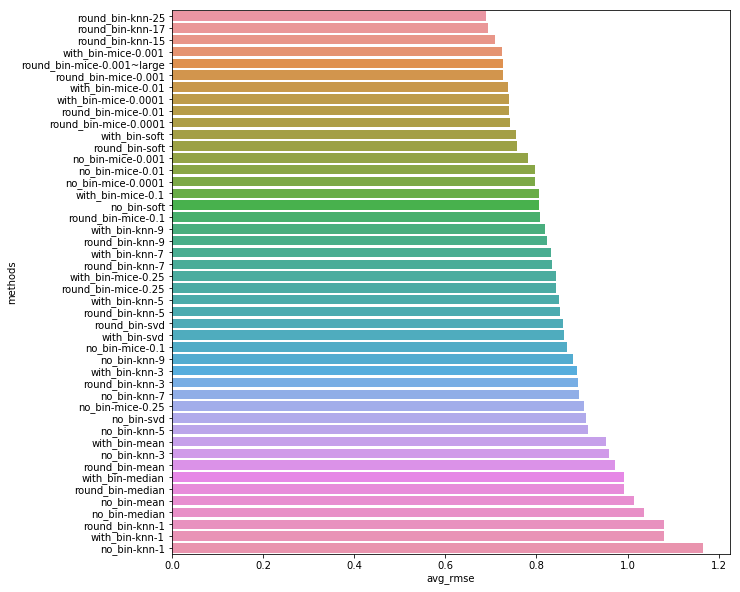

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(y='methods', x='avg_rmse', data = imputes.sort_values(by='avg_rmse'), orient='h',ax=ax)
fig.savefig('impute-bars.png', dpi=fig.dpi, bbox_inches='tight')

Look at that, mean and median impute gave RMSE values \~1, compared to the top performers at \~0.68! Blindly imputing with means would have meant a nearly 50% increase in impute error.

Consider spread before making a decision though. All RMSE test results were stored for each impute-param test so that variance could also be considered in deciding the best imputer. It would do no good to pick a method that achieved 0.5 RMSE on average, but at worst achieved 3 RMSE.

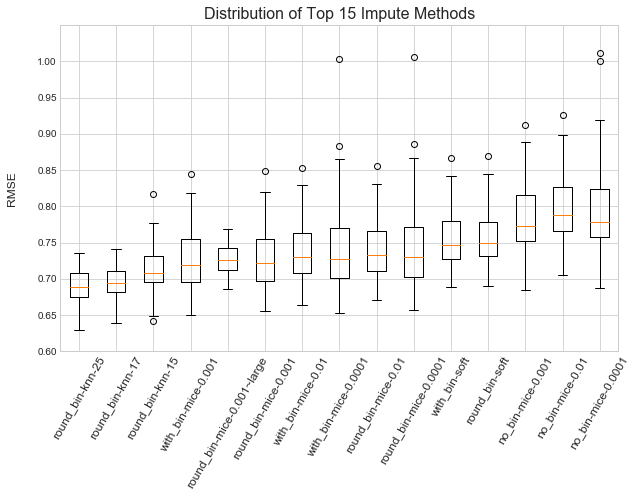

In [43]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(10,6))
plt.boxplot([v for v in imputes.sort_values(by='avg_rmse').rmse.values[:15]])
plt.xticks(range(1,16),imputes.sort_values(by='avg_rmse').methods[:15], rotation = 60, fontsize=12)
plt.ylabel('RMSE',fontsize=12, labelpad = 20)
plt.yticks(np.linspace(.6,1,9))
plt.ylim((.6,1.05))
plt.title('Distribution of Top 15 Impute Methods', fontsize=16)
plt.show()
fig.savefig('impute-boxplot.png', dpi=fig.dpi, bbox_inches='tight')

KNN-25 it is! Not only did it have the lowest mean rmse, it also had the lowest IQR upper bound.

In [45]:
imputes.loc[imputes.methods.str.contains('^round.*knn'),
            ['methods', 'avg_rmse', 'std']].sort_values(by='avg_rmse').head(4)

,methods,avg_rmse,std
33,round_bin-knn-25,0.689426,0.028356
34,round_bin-knn-17,0.693762,0.028226
35,round_bin-knn-15,0.709995,0.030850
32,round_bin-knn-9,0.822474,0.045493


In [50]:
fill_scale_players = {}
for k in scale_players:
    fill_scale_players[k] = scale_players[k].copy()
    print('Imputing {}...'.format(k))
    cols = scale_players[k].drop('result',axis=1)\
    .select_dtypes(exclude=['category','object']).columns
    fill_scale_players[k].loc[:,cols] =\
    fancyimpute.KNN(25, verbose = False).complete(scale_players[k].loc[:,cols])
print('Complete!')

Imputing Top...
Imputing Jungle...
Imputing Middle...
Imputing ADC...
Imputing Support...
Complete!


In [65]:
fill_scale_team = scale_team.copy()
cols = scale_team.drop('result', axis = 1)\
    .select_dtypes(exclude=['category','object']).columns
fill_scale_team.loc[:,cols] = \
fancyimpute.KNN(25, verbose = False).complete(scale_team.loc[:,cols])

- **Round binary cols up or down**

In [52]:
for k in fill_scale_players:
    fill_scale_players[k][b_cols[k]] =\
    fill_scale_players[k][b_cols[k]].applymap(lambda x: 0 if x <=.5 else 1)

In [73]:
team_b_cols = pd.Index(team_b_cols).drop(['triples', 'quadras', 'pentas'])
fill_scale_team[team_b_cols] = \
fill_scale_team[team_b_cols].applymap(lambda x: 0 if x <=.5 else 1)

In [53]:
for k,v in fill_scale_players.items():
    m = v.isnull().sum()
    print('Cols with NaN for',k,':',m[m>0].index.tolist())

Cols with NaN for Top : ['ban1', 'ban2', 'ban3', 'ban4', 'ban5']
Cols with NaN for Jungle : ['ban1', 'ban2', 'ban3', 'ban4', 'ban5']
Cols with NaN for Middle : ['ban1', 'ban2', 'ban3', 'ban4', 'ban5']
Cols with NaN for ADC : ['ban1', 'ban2', 'ban3', 'ban4', 'ban5']
Cols with NaN for Support : ['ban1', 'ban2', 'ban3', 'ban4', 'ban5']


Only remaining NaN values are in the ban selections, which is fine. Those features will be used, but not in such a way where completeness will matter.

### Rescale Data

Now that the NaN's are imputed, the data needs to be rescaled for a few reasons.
- Interpretation (EDA)
- Feature engineering
- Purity of testing data (test deta during modeling will be scaled by train data).
- **CAUTION**: Some predicted features had NaN's as original scaling mean & sd.

In [75]:
fill_players = {}
for k,df in fill_scale_players.items():
    fill_players[k] = patch_scale(df, scale_ref[k],
                                  scale_down=False, verbose = True)

WARNING - Unable to transform: [('5.24', 'fbtime'), ('6.01', 'fbtime'), ('6.02', 'fbtime'), ('6.03', 'fbtime'), ('6.04', 'fbtime'), ('6.05', 'fbtime'), ('6.06', 'fbtime'), ('6.07', 'fbtime'), ('7.04', 'visionwards')]
WARNING - Unable to transform: [('5.24', 'fbtime'), ('6.01', 'fbtime'), ('6.02', 'fbtime'), ('6.03', 'fbtime'), ('6.04', 'fbtime'), ('6.05', 'fbtime'), ('6.06', 'fbtime'), ('6.07', 'fbtime'), ('7.04', 'visionwards')]
WARNING - Unable to transform: [('5.24', 'fbtime'), ('6.01', 'fbtime'), ('6.02', 'fbtime'), ('6.03', 'fbtime'), ('6.04', 'fbtime'), ('6.05', 'fbtime'), ('6.06', 'fbtime'), ('6.07', 'fbtime'), ('7.04', 'visionwards')]
WARNING - Unable to transform: [('5.24', 'fbtime'), ('6.01', 'fbtime'), ('6.02', 'fbtime'), ('6.03', 'fbtime'), ('6.04', 'fbtime'), ('6.05', 'fbtime'), ('6.06', 'fbtime'), ('6.07', 'fbtime'), ('7.04', 'visionwards')]
WARNING - Unable to transform: [('5.24', 'doubles'), ('7.17', 'doubles'), ('5.24', 'fbtime'), ('6.01', 'fbtime'), ('6.02', 'fbtime')

In [76]:
fill_team = patch_scale(fill_scale_team,
                        team_ref,scale_down=False,verbose = True)

WARNING - Unable to transform: [('7.04', 'visionwards'), ('5.24', 'visiblewardclearrate'), ('7.04', 'visiblewardclearrate'), ('7.04', 'invisiblewardclearrate')]


#### One Last Clean

Missing values have all been imputed, everything that was scaled down has been rescaled back up. There's only one little problem left. Negative values in columns that shouldn't have any. Some are *pseudo*-negative, ie $1e-8$ and can just be rounded up to 0. Others are actually negative, due to imputes giving estimates too low for the true range of values. Demonstrated below with a df of before and after imputes on random mid-laner observations (which also shows that values were rescaled correctly!).

In [88]:
had_nan = raw_players['Middle'][['fbtime','monsterkillsenemyjungle','visionwards']].isnull().any(axis=1)
had_nan = had_nan[had_nan == True].index
pd.concat([fill_players['Middle'].loc[had_nan,['cspm','fb','fbtime','visionwards','monsterkillsenemyjungle']],\
           raw_players['Middle'].loc[had_nan,['cspm','fb','fbtime','visionwards','monsterkillsenemyjungle']]], axis = 1).sample(5)

,cspm,fb,fbtime,visionwards,monsterkillsenemyjungle,cspm,fb,fbtime,visionwards,monsterkillsenemyjungle
35131,6.971340,0,4.543050,2.600477,0.000000e+00,6.971340,0.0,4.54305,NaN,0.0
211,8.431579,1,0.200565,3.000000,2.000000e+00,8.431579,1.0,NaN,3.0,2.0
5983,8.173840,0,0.393600,2.000000,0.000000e+00,8.173840,0.0,NaN,2.0,0.0
2911,7.861272,0,-0.165250,1.000000,-4.440892e-16,7.861272,0.0,NaN,1.0,0.0
10058,8.463227,0,-0.685774,1.000000,0.000000e+00,8.463227,0.0,NaN,1.0,0.0


This can be seen more clearly by looking at the different totals between the pseudo-negative and negative values.

In [121]:
neg_cols = playerDF.select_dtypes(exclude=['category','object']).apply(np.min)
neg_cols = neg_cols[neg_cols <0].index # can use same for team
count_neg = lambda x,t: sum(n < t for n in x.select_dtypes(exclude=['category','object'])\
                            .drop(neg_cols, axis=1).values.flatten())
pseudo_neg = 0
true_neg = 0
for k,df in fill_players.items():
    n = count_neg(df,-1e-8)
    pn = count_neg(df, 0) - n
    true_neg += n
    pseudo_neg += pn
    print('WARNING --- Unintended Negatives Found in {}: {}'.format(k, n))
print('\nExcluding: {} --\nThere were {} pseudo-negative \
values and {} negative values'.format(list(neg_cols),pseudo_neg, true_neg))

WARNING --- Unintended Negatives Found in Top: 1042
WARNING --- Unintended Negatives Found in Jungle: 1089
WARNING --- Unintended Negatives Found in Middle: 1062
WARNING --- Unintended Negatives Found in ADC: 1064
WARNING --- Unintended Negatives Found in Support: 1115

Excluding: ['gspd', 'gdat10', 'gdat15', 'xpdat10'] --
There were 3653 pseudo-negative values and 5372 negative values


There's no great way of handling this. Replacing these negative values with the mean wouldn't make sense, since the imputer thought they should be on the lower end of the the range for their respective features. Best solution is just to replace them with the relative minimum from the unimputed data.

In [159]:
for k,df in fill_players.items():
    cols = df.select_dtypes(exclude=['category','object']).drop(neg_cols, axis = 1).columns
    for c in cols.tolist():
        df.loc[df[c] < 0, c] = raw_players[k][c].quantile(0)

for df in fill_players.values():
    t = df.select_dtypes(exclude=['category','object']).apply(np.min)
    print(t[t<0].index)

Index(['gspd', 'gdat10', 'gdat15', 'xpdat10'], dtype='object')
Index(['gspd', 'gdat10', 'gdat15', 'xpdat10'], dtype='object')
Index(['gspd', 'gdat10', 'gdat15', 'xpdat10'], dtype='object')
Index(['gspd', 'gdat10', 'gdat15', 'xpdat10'], dtype='object')
Index(['gspd', 'gdat10', 'gdat15', 'xpdat10'], dtype='object')


In [160]:
cols = fill_team.select_dtypes(exclude=['category','object']).drop(neg_cols, axis = 1).columns
for c in cols.tolist():
    fill_team.loc[fill_team[c] < 0, c] = raw_teams[c].quantile(0)

t = fill_team.select_dtypes(exclude=['category','object']).apply(np.min)
print(t[t<0].index)

Index(['gspd', 'gdat10', 'gdat15', 'xpdat10'], dtype='object')


Finally, the data is clean and ready for use. All that's left to do is save it.

In [161]:
enpickle(fill_players, 'data/fill_players.pickle')
enpickle(fill_team, 'data/fill_team.pickle')